# Property Price Prediction

In [4]:
import pandas as pd 

df = pd.read_csv("immobilien_mit_koordinaten_new.csv")
df.columns

Index(['BOROUGH', 'NEIGHBORHOOD', 'BUILDING CLASS CATEGORY',
       'TAX CLASS AT PRESENT', 'BLOCK', 'LOT', 'EASE-MENT',
       'BUILDING CLASS AT PRESENT', 'ADDRESS', 'APARTMENT NUMBER', ' ZIP CODE',
       'RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 'TOTAL UNITS',
       'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'YEAR BUILT',
       'TAX CLASS AT TIME OF SALE', 'BUILDING CLASS AT TIME OF SALE',
       'SALE PRICE', 'SALE DATE', 'PRICE_PER_SQFT'],
      dtype='object')

In [28]:
from datetime import datetime

datetime.now()

datetime.datetime(2025, 4, 9, 12, 36, 23, 656946)

In [25]:
df["SALE DATE"]

0        2017-11-13 00:00:00
1        2017-01-30 00:00:00
2        2017-04-03 00:00:00
3        2017-12-05 00:00:00
4        2017-04-17 00:00:00
                ...         
27748    2003-07-22 00:00:00
27749    2003-12-30 00:00:00
27750    2003-02-03 00:00:00
27751    2003-11-11 00:00:00
27752    2003-12-17 00:00:00
Name: SALE DATE, Length: 25300, dtype: object


Gradient Boosting Regression Ergebnisse:
RMSE: $1173289.95
R²: 0.5548


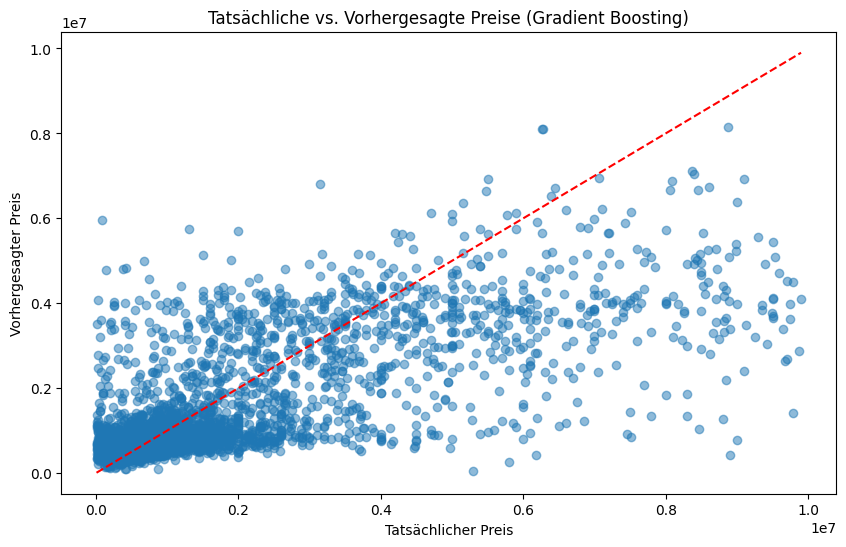

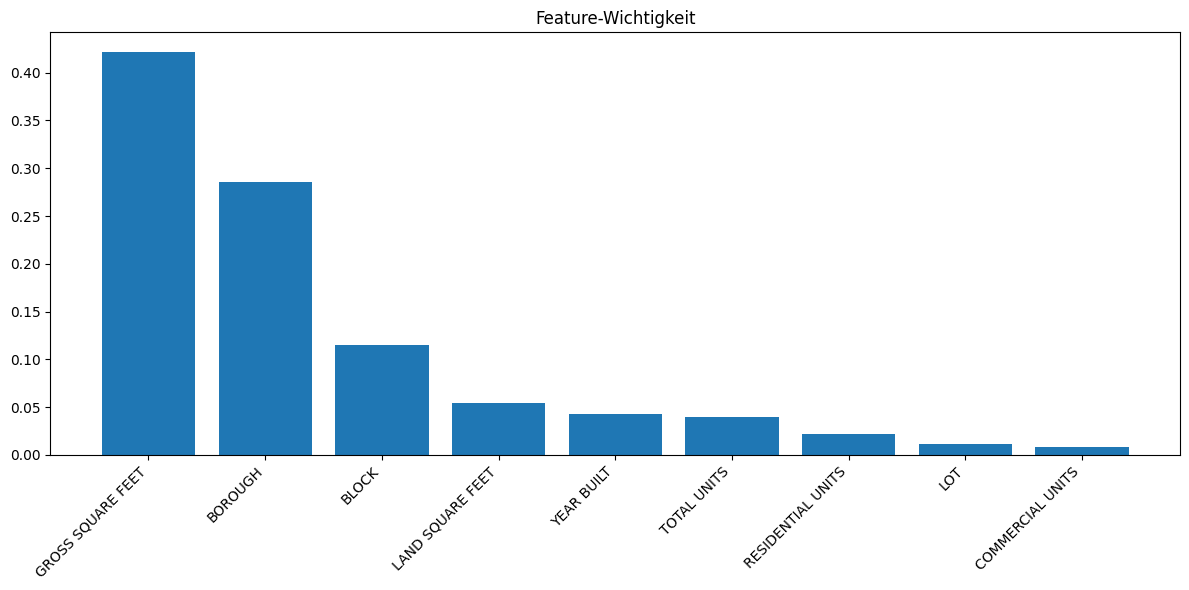


Modell wurde als 'nyc_borough_model.pkl' gespeichert


In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import joblib

# Numerische Features ohne ZIP CODE, aber mit BOROUGH
numeric_features = [
    'BOROUGH',          # Standort (Stadtbezirk)
    'BLOCK',            # Standort
    'LOT',              # Standort
    'RESIDENTIAL UNITS',
    'COMMERCIAL UNITS', 
    'TOTAL UNITS', 
    'LAND SQUARE FEET', 
    'GROSS SQUARE FEET', 
    'YEAR BUILT'
]

# Datenvorverarbeitung
# Fehlende Werte behandeln
df = df.dropna(subset=['SALE PRICE'] + numeric_features)

# Entferne Datensätze mit unrealistischen Preisen
df = df[(df['SALE PRICE'] > 10000) & (df['SALE PRICE'] < 10000000)]

# Features und Zielvariable definieren
X = df[numeric_features]
y = df['SALE PRICE']

# Log-Transformation der Zielvariable (wichtig für Immobilienpreise)
y_log = np.log1p(y)

# Pipeline erstellen mit:
# 1. PowerTransformer für bessere Verteilung numerischer Features
# 2. Gradient Boosting für bessere Vorhersagegenauigkeit
model = Pipeline(steps=[
    ('scaler', PowerTransformer(method='yeo-johnson')),
    ('regressor', GradientBoostingRegressor(
        n_estimators=200, 
        learning_rate=0.1,
        max_depth=5,
        min_samples_split=5,
        loss='huber',  # Robuster gegenüber Ausreißern
        random_state=42
    ))
])

# Trainings- und Testdaten aufteilen
X_train, X_test, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.2, random_state=42)
_, _, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modell trainieren
model.fit(X_train, y_train_log)

# Vorhersagen machen und zurücktransformieren
y_pred_log = model.predict(X_test)
y_pred = np.expm1(y_pred_log)

# Modell evaluieren
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"\nGradient Boosting Regression Ergebnisse:")
print(f"RMSE: ${rmse:.2f}")
print(f"R²: {r2:.4f}")

# Visualisierung der tatsächlichen vs. vorhergesagten Werte
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Tatsächlicher Preis')
plt.ylabel('Vorhergesagter Preis')
plt.title('Tatsächliche vs. Vorhergesagte Preise (Gradient Boosting)')
plt.show()

# Feature-Importance visualisieren
if hasattr(model.named_steps['regressor'], 'feature_importances_'):
    importances = model.named_steps['regressor'].feature_importances_
    indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(12, 6))
    plt.bar(range(X.shape[1]), importances[indices])
    plt.xticks(range(X.shape[1]), [numeric_features[i] for i in indices], rotation=45, ha='right')
    plt.title('Feature-Wichtigkeit')
    plt.tight_layout()
    plt.show()

# Modell speichern
joblib.dump(model, 'nyc_borough_model.pkl')
print("\nModell wurde als 'nyc_borough_model.pkl' gespeichert")

In [22]:
import joblib

model_output_path = "RegressionModel.pkl"

joblib.dump(model, model_output_path)
print(f"Modell wurde erfolgreich unter '{model_output_path}' gespeichert.")

Modell wurde erfolgreich unter 'RegressionModel.pkl' gespeichert.
